# Basic U-net

In [1]:
import os
import imageio.v2 as imageio
from skimage.transform import resize # For preprocessing
import tensorflow as tf

2023-05-07 13:42:32.185469: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read data from disk and set up pipeline

In [2]:
%%time

IMG_WIDTH = 256 # the original images are 250x250. is this a ok way to change size?
IMG_HEIGHT = 256
IMG_CHANNELS = 1 # a grey scale image only has one band for color.
NUM_CLASSES = 1 # 0 = no crater and 1 = crater

#### Training data ####
TRAIN_PATH = '/workspace/data/final_data_05m/training/'
IMG_DIR = 'hillshade'
GT_DIR = 'labels'
X_train_pit = []
Y_train_pit = []

# load from disk
img_path = os.path.join(TRAIN_PATH, IMG_DIR)
gt_path = os.path.join(TRAIN_PATH, GT_DIR)
for image in (os.listdir(img_path)):
    img = imageio.imread(os.path.join(img_path, image))

    img = resize(img, (IMG_WIDTH, IMG_HEIGHT,1), mode='constant', preserve_range=True)
    
    mask = imageio.imread(os.path.join(gt_path, image))
    mask = resize(mask, (IMG_WIDTH, IMG_HEIGHT, 1), preserve_range=True, order=0).astype(int)
    
    X_train_pit.append(img)
    Y_train_pit.append(mask)
    
print('loaded training data')
#### Test data ####
TEST_PATH = '/workspace/data/final_data_05m/testing/'
IMG_DIR = 'hillshade'
GT_DIR = 'labels'
X_test_pit = []
Y_test_pit = []

# load from disk
img_path = os.path.join(TEST_PATH, IMG_DIR)
gt_path = os.path.join(TEST_PATH, GT_DIR)
for image in (os.listdir(img_path)):
    img = imageio.imread(os.path.join(img_path, image))
    img = resize(img, (IMG_WIDTH, IMG_HEIGHT,1), mode='constant', preserve_range=True)
    mask = imageio.imread(os.path.join(gt_path, image))
    mask = resize(mask, (IMG_WIDTH, IMG_HEIGHT, 1), preserve_range=True, order=0).astype(int)
    
    X_test_pit.append(img)
    Y_test_pit.append(mask)
print('loaded testing data')
    



loaded training data
loaded testing data
CPU times: user 17.3 s, sys: 2.09 s, total: 19.3 s
Wall time: 24.5 s


In [3]:
%%time

# convert list of numpy arrays into tensorflow dataset for further processing
train_images_pit = tf.data.Dataset.from_tensor_slices((X_train_pit, Y_train_pit))
test_images_pit = tf.data.Dataset.from_tensor_slices((X_test_pit, Y_test_pit))


BATCH_SIZE = 16
BUFFER_SIZE = 128

# training
train_batches_pit  = (train_images_pit 
                    .cache() # cache data
                    .shuffle(BUFFER_SIZE) # fill buffer, sample from it and replace with new items (buffer size > training set for perfect shuffling)
                    .batch(BATCH_SIZE)  
                    .repeat() 
                    .prefetch(buffer_size=128))
# testing
test_batches_pit  = (test_images_pit  
                    .cache() # cache data
                    .shuffle(BUFFER_SIZE) # fill buffer, sample from it and replace with new items (buffer size > training set for perfect shuffling)
                    .batch(BATCH_SIZE)  
                    .repeat(1)  # repeat dataset idefinetely
                    .prefetch(buffer_size=128)) 

2023-05-07 13:42:58.135922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-07 13:42:58.143092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-07 13:42:58.143283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-07 13:42:58.144234: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate 

CPU times: user 3min 2s, sys: 2.5 s, total: 3min 4s
Wall time: 3min 4s


## Add recall and f1-score as custom metrics

In [4]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Define a basic U-net

In [32]:
%%time
#tf.keras.mixed_precision.set_global_policy("mixed_float16")
#tf.keras.mixed_precision.set_global_policy("float32")
#Build the model
tf.keras.utils.set_random_seed(0)
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
NUM_CLASSES = 1

# augmentation
#c0 = tf.keras.layers.RandomFlip(mode='horizontal_and_vertical')(inputs)
#c0 = tf.keras.layers.RandomRotation(0.1)(c0)

#Contraction path
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1) # to prevent overfitting
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1))(c9)

model_pit = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_pit.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True), metrics=['acc', f1_m, recall_m])

CPU times: user 213 ms, sys: 32.7 ms, total: 246 ms
Wall time: 241 ms


In [33]:
def add_sample_weights(image, label):
    # The weights for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    class_weights = tf.constant([0.01, 1]) # the first weight is for the background and the second for the craters.
    class_weights = class_weights/tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label at each pixel as an 
    # index into the `class weights` .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

## Train the model

In [34]:
%%time

callback = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=20)

#result = model_pit.fit(train_batches_pit.map(add_sample_weights),validation_data=test_batches_pit, epochs=100, steps_per_epoch=83, callbacks=[callback])
result = model_pit.fit(train_batches_pit,validation_data=test_batches_pit, epochs=100, steps_per_epoch=83, callbacks=[callback])

Epoch 1/100
83/83 [==============================] - 8s 85ms/step - loss: 0.0232 - acc: 0.9886 - f1_m: 1.7754e-04 - recall_m: 2.8468e-04 - val_loss: 0.0194 - val_acc: 0.9887 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
83/83 [==============================] - 7s 82ms/step - loss: 0.0195 - acc: 0.9889 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.0196 - val_acc: 0.9887 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
83/83 [==============================] - 7s 82ms/step - loss: 0.0194 - acc: 0.9889 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.0196 - val_acc: 0.9887 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
83/83 [==============================] - 7s 82ms/step - loss: 0.0193 - acc: 0.9889 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.0192 - val_acc: 0.9887 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 5/100
83/83 [==============================] - 7s 82ms/step - loss: 0.0189 - acc: 0.9890 - f1_m: 0

KeyboardInterrupt: 

In [29]:
results = model_pit.evaluate(test_batches_pit)

21/21 [==============================] - 0s 20ms/step - loss: 0.1996 - acc: 0.9887 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00


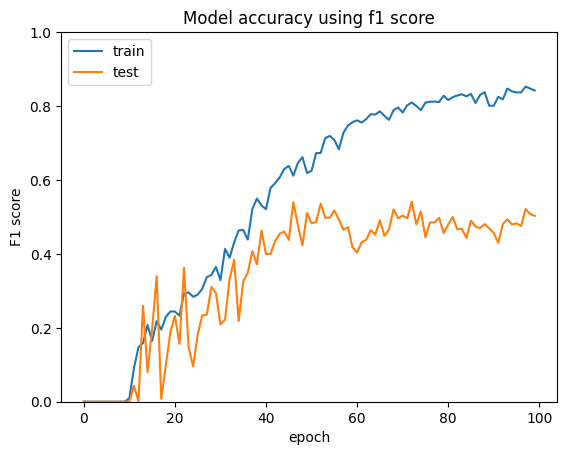

In [8]:
# summarize history for accuracy
import matplotlib.pyplot as plt
#plt.plot(result.history['f1_m'])
#plt.plot(result.history['val_f1_m'])


plt.plot(result.history['f1_m'])


plt.plot(result.history['val_f1_m'])


plt.title('Model accuracy using f1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 228ms/step


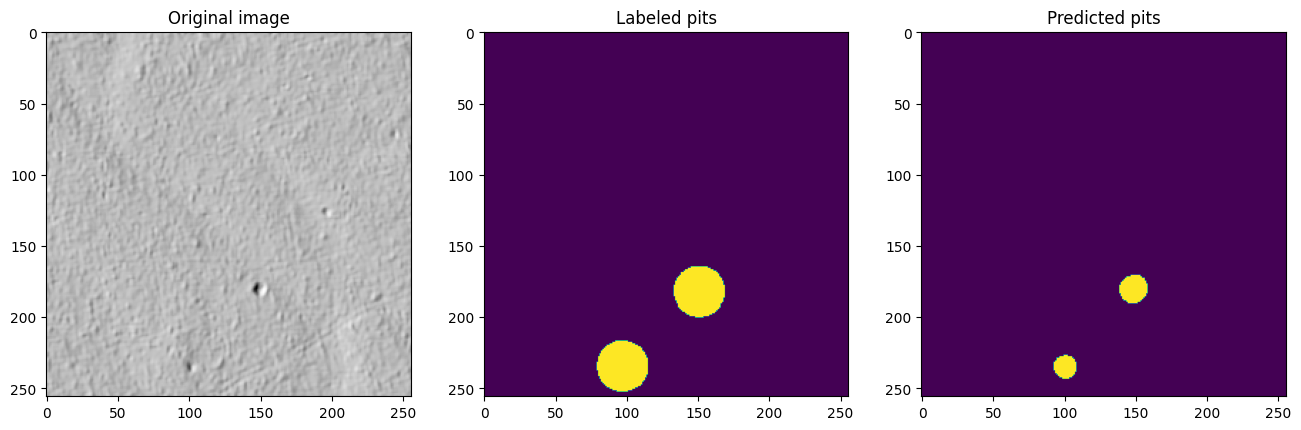

In [9]:
# size of plot
import numpy as np
plt.rcParams['figure.figsize'] = [16, 16]
f, axarr = plt.subplots(1,3)
i = 42
#image 
testimage = X_test_pit[i]
orgimage = np.squeeze(testimage)

# label
testlabel = Y_test_pit[i]
testlabel = np.squeeze(testlabel)

# prediction
testimage = X_test_pit[i]
testimage = np.reshape(testimage,[1,256,256,1])
prediction_pit = model_pit.predict(testimage)
pred_pit = np.squeeze(prediction_pit)


# Image
axarr[0].set_title('Original image')
axarr[0].imshow(orgimage, cmap='Greys_r')

# Label
axarr[1].set_title('Labeled pits')
axarr[1].imshow(testlabel)

# Prediction
axarr[2].set_title('Predicted pits')
axarr[2].imshow(pred_pit>0.5)